In [1]:
# Settings for notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Show Python version
import platform
platform.python_version()

'3.7.7'

In [2]:
try:
    import scrapy
except:
    !pip3 install scrapy
    import scrapy
from scrapy.crawler import CrawlerProcess

In [3]:
import json
import logging

class QuotesSpider(scrapy.Spider):
    name = "quotes"
    start_urls = [
        'http://www.ph.lacounty.gov/media/Coronavirus/locations.htm'
    ]
    custom_settings = {
        'LOG_LEVEL': logging.WARNING,
        'FEED_FORMAT':'json',                                 # Used for pipeline 2
        'FEED_URI': 'quoteresult.json'                        # Used for pipeline 2
    }
    
    def parse(self, response):
        cities = response.xpath('//table/tr/td[1]').extract()
        cases = response.xpath('//table/tr/td[2]').extract()
        rates = response.xpath('//table/tr/td[3]').extract()
        cities = list(map(lambda x: x.replace('<td>','').replace('</td>',''), cities))
        cases = list(map(lambda x: x.replace('<td>','').replace('</td>',''), cases))
        rates = list(map(lambda x: x.replace('<td>','').replace('</td>',''), rates))
        alist=[]
        lacitiesdata = { "lacitiescovid": alist }
        i = 0
        for city in cities:
            arec = { 'city': city, 'cases': cases[i] , 'rate':rates[i]}
            i=i+1
            alist.append(arec)
        with open('lacovidinfo.json', 'w') as jsonfile:
            print(json.dump(lacitiesdata, jsonfile, indent=4))


In [4]:
process = CrawlerProcess({
    'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)'
})

process.crawl(QuotesSpider)
process.start()


2020-05-28 21:16:36 [scrapy.utils.log] INFO: Scrapy 1.8.0 started (bot: scrapybot)
2020-05-28 21:16:36 [scrapy.utils.log] INFO: Versions: lxml 4.5.0.0, libxml2 2.9.10, cssselect 1.1.0, parsel 1.5.2, w3lib 1.21.0, Twisted 20.3.0, Python 3.7.7 (default, Mar 11 2020, 09:39:49) - [GCC 5.4.0 20160609], pyOpenSSL 19.1.0 (OpenSSL 1.1.1d  10 Sep 2019), cryptography 2.8, Platform Linux-4.19.84-microsoft-standard-x86_64-with-debian-buster-sid
2020-05-28 21:16:36 [scrapy.crawler] INFO: Overridden settings: {'FEED_FORMAT': 'json', 'FEED_URI': 'quoteresult.json', 'LOG_LEVEL': 30, 'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)'}


None


In [5]:
import pandas as pd

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

res = pd.read_json('lacovidinfo.json')
#with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
#    print(res)

In [6]:
x=res.to_dict('record')
deathrates=[]
infections=[]
y=x[27]['lacitiescovid']
infected= int(y['cases'])
y=x[41]['lacitiescovid']
deaths = int(y['cases'])

deathrates.append( { 'asian':deaths/infected})
infections.append( {'asian': infected})

y=x[28]['lacitiescovid']
infected= int(y['cases'])
y=x[42]['lacitiescovid']
deaths = int(y['cases'])

deathrates.append( { 'black':deaths/infected})
infections.append( {'black': infected})

y=x[29]['lacitiescovid']
infected= int(y['cases'])
y=x[43]['lacitiescovid']
deaths = int(y['cases'])

deathrates.append( { 'latino':deaths/infected})
infections.append( {'latino': infected})

y=x[31]['lacitiescovid']
infected= int(y['cases'])
y=x[45]['lacitiescovid']
deaths = int(y['cases'])

deathrates.append( { 'white':deaths/infected})
infections.append( {'white': infected})


print(deathrates)
print(infections)

[{'asian': 0.12547926106657373}, {'black': 0.13002114164904863}, {'latino': 0.04928021026223045}, {'white': 0.10476865803935473}]
[{'asian': 2869}, {'black': 1892}, {'latino': 16741}, {'white': 5641}]


In [7]:
# among latino population the survival rate is higher 0.049 vs. 0.12 (asian) and 0.13 (black)
# asians' high death rate may be due to older infected patients
# black may be unfairly impacted due to lack of care and hospitalizations, but it is not clear.
# from https://en.wikipedia.org/wiki/Demographics_of_Los_Angeles_County

demographics = []

demographics.append( {'asian': 1347782})
demographics.append( {'black': 844048})
demographics.append( {'latino': 4644328})
demographics.append( {'white': 5126367})

print(demographics)
print('asian infection rate',infections[0]['asian']/demographics[0]['asian']*100)
print('black infection rate',infections[1]['black']/demographics[1]['black']*100)
print('latino infection rate',infections[2]['latino']/demographics[2]['latino']*100)
print('white infection rate',infections[3]['white']/demographics[3]['white']*100)


[{'asian': 1347782}, {'black': 844048}, {'latino': 4644328}, {'white': 5126367}]
asian infection rate 0.21286825317447478
black infection rate 0.22415786779898775
latino infection rate 0.36046119051023096
white infection rate 0.110038941808107


In [8]:
# the latino folks are disproportionately affected and infected at 3 times the rate of whites.  
# They also recover better, with survival rate of 0.049.  Most likely younger population
# of latinos that are critical workers who are impacted far more than others.
#
# asian and black communities are infected more or less proportionately.  
# White are much less affected in comparison.

In [9]:
lcc = res.lacitiescovid
alist = []
llist = []
for x in lcc:
    if x['cases'] == '' or  x['cases'] == '--': 
        continue
    if x['rate'] == '--' or x['rate'] == '':
        continue
    if not is_number(x['cases']):
        continue
    if not is_number(x['rate']):
        continue
    anent = { 'city': x['city'], 'cases': float(x['cases']), 'rate': float(x['rate'])}
    alist.append(anent)
    if not x['city'].startswith('Los Angeles - '):
        continue
    llist.append(anent)
adf = pd.DataFrame(alist)
ldf = pd.DataFrame(llist)
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print(ldf)

                                      city  cases     rate
0            Los Angeles - Adams-Normandie   51.0   621.80
1                     Los Angeles - Alsace   47.0   377.66
2    Los Angeles - Angeles National Forest    0.0     0.00
3           Los Angeles - Angelino Heights   16.0   639.49
4                     Los Angeles - Arleta  271.0   788.48
5            Los Angeles - Atwater Village   51.0   347.74
6              Los Angeles - Baldwin Hills  162.0   520.48
7                    Los Angeles - Bel Air   35.0   415.23
8              Los Angeles - Beverly Crest   37.0   295.41
9                Los Angeles - Beverlywood   37.0   280.88
10            Los Angeles - Boyle Heights*  653.0   751.58
11                 Los Angeles - Brentwood   78.0   251.98
12                 Los Angeles - Brookside    0.0     0.00
13          Los Angeles - Cadillac-Corning   29.0   407.25
14               Los Angeles - Canoga Park  486.0   744.38
15                   Los Angeles - Carthay   77.0   536.

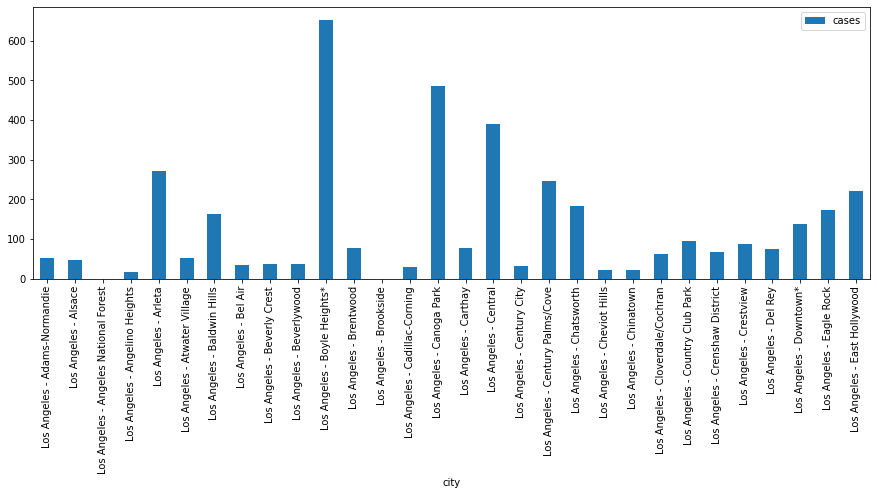

In [10]:
ldf[:30].plot(kind='bar', x='city', y='cases', figsize=(15,5))

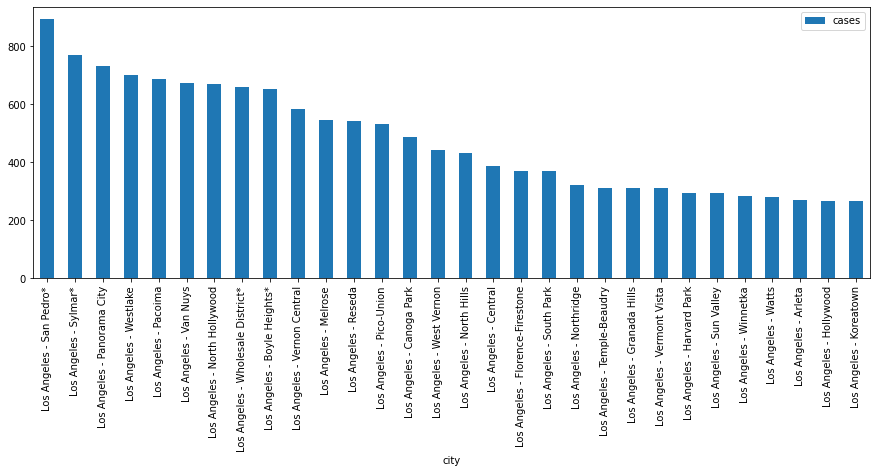

In [11]:
ldf.sort_values(by='cases', ascending=False)[:30].plot(kind='bar', x='city', y='cases', figsize=(15,5))

In [12]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print(ldf.sort_values(by='rate', ascending=False))


                                      city  cases     rate
62            Los Angeles - Little Armenia  191.0  2380.06
134      Los Angeles - Wholesale District*  661.0  1829.56
85                Los Angeles - Pico-Union  531.0  1269.06
132                 Los Angeles - Westlake  703.0  1184.40
94                Los Angeles - San Pedro*  893.0  1144.31
122           Los Angeles - Vernon Central  584.0  1123.12
120           Los Angeles - Vermont Square   84.0  1097.04
16                   Los Angeles - Central  389.0   997.64
99                Los Angeles - South Park  369.0   972.05
83             Los Angeles - Panorama City  731.0   971.43
100          Los Angeles - St Elmo Village   44.0   959.86
51     Los Angeles - Historic Filipinotown  131.0   944.48
105                  Los Angeles - Sylmar*  772.0   936.92
80                   Los Angeles - Pacoima  686.0   891.15
116           Los Angeles - Valley Village  207.0   837.38
59          Los Angeles - Lakeview Terrace  108.0   822.

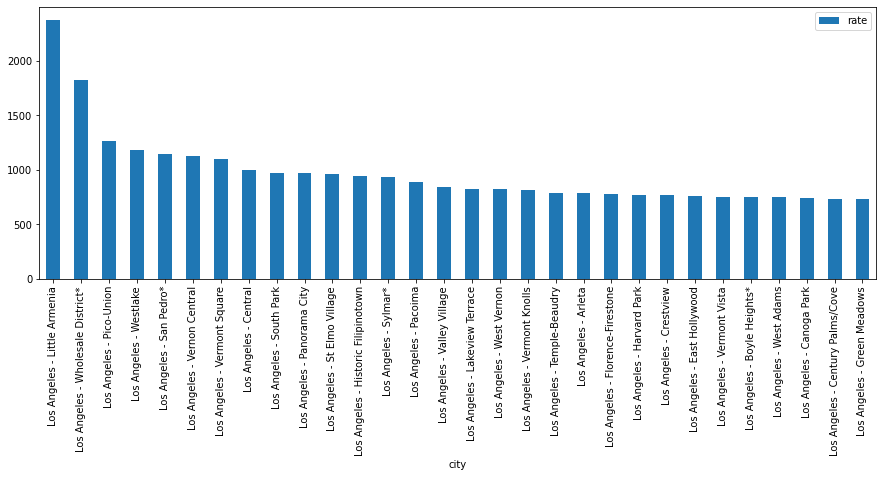

In [13]:
ldf.sort_values(by='rate', ascending=False)[:30].plot(kind='bar', x='city', y='rate', figsize=(15,5))

In [14]:
import os
import psycopg2

DATABASE_URL = os.environ['DATABASE_URL']

conn = psycopg2.connect(DATABASE_URL, sslmode='require')

In [15]:
cur = conn.cursor()
cur.execute("SELECT * FROM pg_catalog.pg_tables WHERE schemaname != 'pg_catalog' AND schemaname != 'information_schema';")
cur.fetchall()

[('public', 'test', 'aiixvwniavdldj', None, True, False, False, False),
 ('public', 'lacovid2', 'aiixvwniavdldj', None, True, False, False, False)]

In [16]:
#cur.execute("CREATE TABLE test (id serial PRIMARY KEY, num integer, data varchar);")

In [17]:
#cur.execute("INSERT INTO test (num, data) VALUES (%s, %s)",(100, "abc'def"))

In [18]:
cur.execute("SELECT * FROM test;")
cur.fetchone()

(1, 100, "abc'def")

In [19]:
cur.execute("DROP TABLE lacovid2;")
cur.execute("CREATE TABLE lacovid2 (id serial, city varchar PRIMARY KEY, cases float, rate float);")

In [20]:
for d in ldf.to_dict('records'):
   cur.execute("INSERT INTO lacovid2 (city, cases, rate) VALUES (%s, %s, %s)",(d['city'],d['cases'], d['rate']))

In [21]:
cur.execute("SELECT * FROM lacovid2 ORDER BY rate;")
cur.fetchall()

[(3, 'Los Angeles - Angeles National Forest', 0.0, 0.0),
 (13, 'Los Angeles - Brookside', 0.0, 0.0),
 (69, 'Los Angeles - Mandeville Canyon', 1.0, 32.01),
 (82, 'Los Angeles - Palisades Highlands', 3.0, 78.0),
 (87, 'Los Angeles - Playa Del Rey', 3.0, 93.87),
 (38, 'Los Angeles - Faircrest Heights', 4.0, 111.11),
 (134, 'Los Angeles - Westwood', 67.0, 123.82),
 (85, 'Los Angeles - Park La Brea', 19.0, 139.91),
 (91, 'Los Angeles - Regent Square', 4.0, 143.88),
 (105, 'Los Angeles - Sycamore Square', 1.0, 154.56),
 (112, 'Los Angeles - Toluca Woods', 3.0, 161.46),
 (132, 'Los Angeles - Westchester', 92.0, 178.28),
 (70, 'Los Angeles - Mar Vista', 80.0, 188.36),
 (119, 'Los Angeles - Venice', 65.0, 191.83),
 (130, 'Los Angeles - West Los Angeles', 79.0, 209.91),
 (88, 'Los Angeles - Playa Vista', 23.0, 210.1),
 (110, 'Los Angeles - Toluca Lake', 19.0, 218.29),
 (68, 'Los Angeles - Manchester Square', 19.0, 222.59),
 (74, 'Los Angeles - Miracle Mile', 41.0, 227.97),
 (21, 'Los Angeles - C

In [22]:
cur.execute("SELECT * FROM lacovid2 ORDER BY cases;")
cur.fetchall()

[(3, 'Los Angeles - Angeles National Forest', 0.0, 0.0),
 (13, 'Los Angeles - Brookside', 0.0, 0.0),
 (69, 'Los Angeles - Mandeville Canyon', 1.0, 32.01),
 (105, 'Los Angeles - Sycamore Square', 1.0, 154.56),
 (82, 'Los Angeles - Palisades Highlands', 3.0, 78.0),
 (112, 'Los Angeles - Toluca Woods', 3.0, 161.46),
 (87, 'Los Angeles - Playa Del Rey', 3.0, 93.87),
 (38, 'Los Angeles - Faircrest Heights', 4.0, 111.11),
 (91, 'Los Angeles - Regent Square', 4.0, 143.88),
 (111, 'Los Angeles - Toluca Terrace', 6.0, 459.42),
 (48, 'Los Angeles - Harbor Pines', 9.0, 373.6),
 (36, 'Los Angeles - Exposition', 9.0, 270.6),
 (125, 'Los Angeles - View Heights', 9.0, 243.64),
 (94, 'Los Angeles - Reynier Village', 10.0, 236.52),
 (96, 'Los Angeles - Shadow Hills', 11.0, 247.64),
 (114, 'Los Angeles - University Hills', 11.0, 320.79),
 (71, 'Los Angeles - Marina Peninsula', 12.0, 275.23),
 (4, 'Los Angeles - Angelino Heights', 16.0, 639.49),
 (33, 'Los Angeles - Elysian Park', 16.0, 280.11),
 (65, 'L

In [23]:
cur.execute("SELECT * FROM lacovid2 WHERE city = 'Los Angeles - Eagle Rock';")
cur.fetchall()

[(29, 'Los Angeles - Eagle Rock', 172.0, 434.46)]

In [24]:
conn.commit()
cur.close()
conn.close()